In [93]:
import matplotlib.pyplot as plt
import numpy as np
from mp_api.client import MPRester
import pandas as pd
from joblib import Parallel, delayed
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [94]:
api_anass = "bo70Q5XVKyZdImV77bFXHO2cDKdvVQ6F"

In [95]:
from utils import calculate_xrd_from_cif, Voigt
import glob

In [96]:
files_cif = glob.glob("./data/cif_files/*.cif")

In [97]:
import os
# Removes the previous parquet file if it exists
try:
    os.remove("./data/pow_xrd.parquet")
except Exception as e:
    pass

In [98]:
f = files_cif[8]

In [106]:
signal = calculate_xrd_from_cif(f, 5.0, 0.721)

In [107]:
angles = signal["Angles"]
intensities = signal["Intensities"]

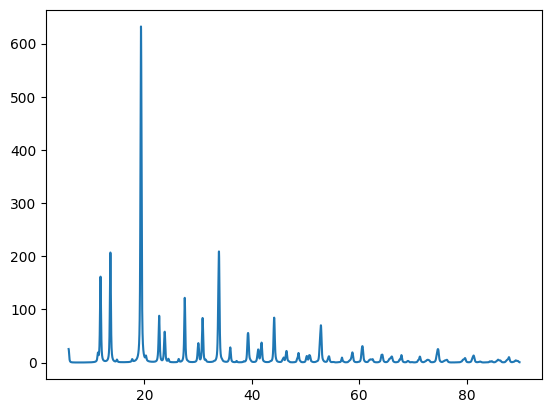

In [108]:
plt.plot(angles, intensities)

In [110]:
data = Parallel(n_jobs=64)(delayed(calculate_xrd_from_cif)(f, 5.0, 0.721) for f in files_cif)

/home/experiences/grades/bellachehab/anaconda3/envs/XRD/lib/python3.10/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/experiences/grades/bellachehab/anaconda3/envs/XRD/lib/python3.10/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/experiences/grades/bellachehab/anaconda3/envs/XRD/lib/python3.10/site-packages/pymatgen/io/cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.

In [111]:
len(data)

118399

In [ ]:
data[0]

In [112]:
pandas_df = pd.DataFrame(data)

In [113]:
pandas_df.to_parquet('./data/pow_xrd.parquet')

In [10]:
xrd_pattern = data[0]['XRD Pattern']

In [11]:
xrd_pattern

(array([12.59040113, 12.59803061, 12.60566009, ..., 88.86232302,
        88.8699525 , 88.87758198]),
 array([61.39281978, 60.61084365, 58.28523111, ...,  4.55978481,
         4.73233441,  4.78698316]))

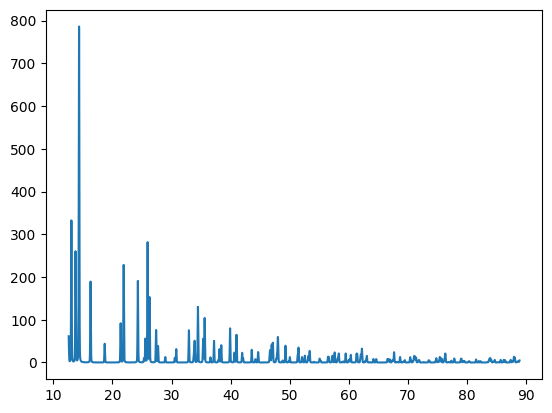

In [12]:
plt.plot(xrd_pattern[0], xrd_pattern[1])

In [13]:
from utils import MinMaxScaling

In [14]:
intensities = MinMaxScaling(xrd_pattern[1])

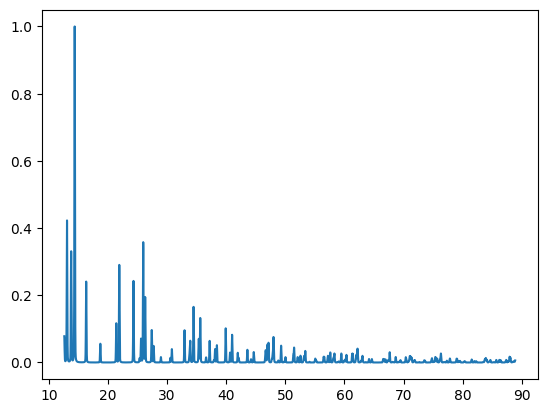

In [15]:
plt.plot(xrd_pattern[0], intensities)

In [16]:
def transform_signal(signal):
    xrd_pattern = signal['XRD Pattern']
    intensites = MinMaxScaling(xrd_pattern[1])
    angles = xrd_pattern[0]
    signal['XRD Pattern'] = (angles, intensites)
    return signal

In [17]:
data = [transform_signal(signal) for signal in data]

In [18]:
df = pd.DataFrame(data)

In [19]:
df.head()

,XRD Pattern,Space Group
0,"([12.590401131833666, 12.598030612866806, 12.6...",P6_3/mmc
1,"([13.473811722436789, 13.48141264792502, 13.48...",Fm-3m
2,"([13.787045712841245, 13.794550876833762, 13.8...",Im-3m
3,"([3.8064543216899196, 3.8150745119469893, 3.82...",I4cm
4,"([5.048069571619445, 5.056554943450839, 5.0650...",F-43m


In [20]:
df.to_parquet("./data/pow_xrd3.parquet", engine="pyarrow")

In [21]:
df.head()

,XRD Pattern,Space Group
0,"([12.590401131833666, 12.598030612866806, 12.6...",P6_3/mmc
1,"([13.473811722436789, 13.48141264792502, 13.48...",Fm-3m
2,"([13.787045712841245, 13.794550876833762, 13.8...",Im-3m
3,"([3.8064543216899196, 3.8150745119469893, 3.82...",I4cm
4,"([5.048069571619445, 5.056554943450839, 5.0650...",F-43m


In [22]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from pymatgen.symmetry.groups import SpaceGroup

In [71]:
class XRDPatternDataset(Dataset):
    """Class that generates the XRD pattern, the angles, the intensity and the space group to be predicted"""
    def __init__(self, df_xrd, device):
        """Constructor of the class
            Args:
                - xrd_file : Parquet file containing all the data
                - space_group_mapping : dictionary with the space groups as values
        """
        self.dataframe = df_xrd
        space_groups = self.dataframe["Space Group"].unique().tolist()
        space_group_mapping = {}
        for i, group in enumerate(space_groups):
            space_group_mapping[group] = i+1
        self.space_group_mapping = space_group_mapping
        self.nb_space_group = len(space_group_mapping)
        self.device = device

    def __len__(self):
        """Returns the size of the dataframe (number of rows)"""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Returns the information at row idx
            Args:
                - idx (int) : index where to get information
            Returns:
                - angles, intensities and space_group tensors
        """
        xrd_pattern = self.dataframe.iloc[idx, 0]
        intensities = np.array(xrd_pattern[0], dtype=float)
        angles = np.array(xrd_pattern[1], dtype=float)
        intensities = torch.tensor(intensities, dtype=torch.float32).to(self.device)
        angles = torch.tensor(angles, dtype=torch.float32).to(self.device)
        space_group = torch.tensor(self.space_group_mapping[self.dataframe.iloc[idx, 1]], dtype=torch.long).to(self.device)
        return angles, intensities, space_group

In [72]:
#from dataset import XRDPatternDataset

In [73]:
xrd = XRDPatternDataset(df, device)

In [74]:
xrd[10]

(tensor([0.0086, 0.0085, 0.0081,  ..., 0.0032, 0.0031, 0.0029], device='cuda:0'),
 tensor([ 4.8519,  4.8604,  4.8690,  ..., 89.9658, 89.9743, 89.9828],
        device='cuda:0'),
 tensor(10, device='cuda:0'))

In [75]:
nb_space_groups = xrd.nb_space_group
print("number of space groups:", nb_space_groups)

number of space groups: 224


In [76]:
from torch.utils.data import random_split, DataLoader

In [77]:
trainset, testset = random_split(xrd, [0.75, 0.25])

In [78]:
batch_size = 16

In [79]:
trainloader = DataLoader(trainset, batch_size=batch_size)
testloader = DataLoader(testset, batch_size=batch_size)

In [80]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
from torch import optim 

In [89]:
### Next step : train the model on data to ensure that it works fine
def train(train_loader, cnn, learning_rate, num_epochs, device):
    """Trains the CNN on training data"""
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)

    print("Begin training :")
    for epoch in range(num_epochs):
        running_loss = 0.0
        print("epoch: ", epoch)

        # For each batch in the loader
        for angles, inputs, labels in train_loader:
            # Set the gradients back to 0
            optimizer.zero_grad()

            # Apply the model
            outputs = cnn(torch.unsqueeze(inputs, 1))

            # Compare between the outputs from the CNN and the labels
            loss = criterion(outputs, labels)

            # Compute the gradients
            loss.backward()

            # Performs a single optimization step (parameter update)
            optimizer.step()
            print("item", loss.item())

            running_loss += loss.item()

        # Print the average loss for one epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("Finished training !")

In [83]:
def compute_accuracy(test_loader, cnn, num_epochs, device):
    """Compute the accuracy of the model
        Args:
        - test_loader : data that can be loaded in batches
        - cnn : the cnn model
        - num_epochs : number of iterations
    """
    for epoch in range(num_epochs):
        accuracy = 0
        count = 0
        for angles, inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            y_pred = cnn(torch.unsqueeze(inputs, 1))
            accuracy += (torch.argmax(y_pred, dim=1) == labels).float().sum()
            count += len(labels)
        accuracy /= count
        print("Epoch %d: model accuracy %.2f%%" % (epoch, accuracy * 100))

In [84]:
import torch.nn as nn

class ConvNN(nn.Module):
    
    def __init__(self):
        super(ConvNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=80, kernel_size=100, stride=5, padding=(100-1)//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AvgPool1d(kernel_size=3, stride=2),

            nn.Conv1d(in_channels=80, out_channels=80, kernel_size=50, stride=5, padding=(50-1)//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AvgPool1d(kernel_size=3),

            nn.Conv1d(in_channels=80, out_channels=80, kernel_size=25, stride=2, padding=(25-1)//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AvgPool1d(kernel_size=3)
        )

        def _vector_size(input_shape):
            """Compute the size of the flattened vector after the convolutional layers."""
            # Create a dummy input with the given input shape
            dummy_input = torch.randn(1, *input_shape)

            # Pass the dummy input through the convolutional layers
            output = self.conv_layers(dummy_input)

            # Return the size of the flattened vector
            return int(output.numel())

        self.flattened_size = _vector_size((1, 10000))

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 2300),  # The size 312 might need adjustment depending on the exact output shape after pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2300, 1150),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1150, nb_space_groups),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [85]:
model = ConvNN()
model = model.to(device)

In [86]:
num_epochs = 10
learning_rate = 0.01

In [90]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [91]:
train(trainloader, model, learning_rate, num_epochs, device)

Begin training :
epoch:  0


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
